torch.Size([2, 8, 8]) torch.Size([2, 8, 8])
tensor(35.)


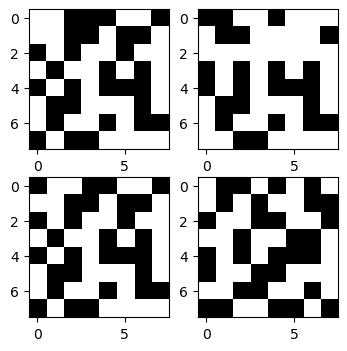

In [41]:
import torchmetrics
import torch
import matplotlib.pyplot as plt
predicted = torch.tensor([[[1, 1, 0, 0, 0, 1, 1, 0],
                         [1, 1, 0, 0, 1, 0, 0, 1],
                         [0, 1, 0, 1, 1, 0, 1, 1],
                         [1, 0, 1, 1, 0, 1, 0, 1],
                         [0, 1, 0, 1, 0, 0, 0, 1],
                         [1, 0, 0, 1, 1, 1, 0, 1],
                         [1, 0, 1, 1, 0, 1, 0, 0],
                         [0, 1, 0, 0, 1, 1, 1, 1]],
                         [[0, 1, 1, 0, 0, 1, 1, 0],
                     [1, 1, 0, 0, 1, 0, 0, 1],
                     [0, 1, 0, 1, 1, 0, 1, 1],
                     [1, 0, 1, 1, 0, 1, 0, 1],
                     [0, 1, 0, 1, 0, 0, 0, 1],
                     [1, 0, 0, 1, 1, 1, 0, 1],
                     [1, 0, 1, 1, 0, 1, 0, 0],
                     [0, 1, 0, 0, 1, 1, 1, 1]]], dtype=torch.float32)

target = torch.tensor([[[0, 0, 1, 1, 0, 1, 1, 1],
                      [1, 0, 0, 1, 1, 1, 1, 0],
                      [1, 1, 1, 1, 1, 1, 1, 1],
                      [0, 1, 0, 1, 0, 1, 0, 1],
                      [0, 1, 0, 1, 0, 0, 0, 1],
                      [1, 0, 0, 1, 1, 1, 0, 1],
                      [1, 0, 1, 1, 0, 1, 0, 0],
                      [1, 1, 0, 0, 1, 1, 1, 1]],
                      [[1, 0, 0, 1, 0, 1, 0, 1],
                     [1, 0, 1, 0, 1, 1, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 0],
                     [1, 1, 0, 1, 1, 0, 0, 1],
                     [0, 1, 0, 1, 0, 0, 0, 1],
                     [0, 1, 1, 0, 0, 1, 1, 1],
                     [1, 1, 0, 0, 1, 1, 0, 1],
                     [0, 0, 1, 1, 0, 0, 1, 0]]], dtype=torch.long)

print(predicted.size(), target.size())
fig, axs = plt.subplots(2,2, figsize=(4,4))
axs[0,0].imshow(predicted[0], cmap="gray")
axs[0,1].imshow(target[0], cmap="gray")
axs[1,0].imshow(predicted[1], cmap="gray")
axs[1,1].imshow(target[1], cmap="gray")
print(predicted[0].sum())

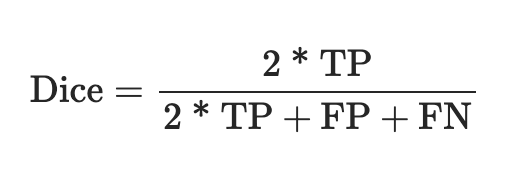

In [44]:
import torch
from torch import Tensor
from torchmetrics import Metric
from torchmetrics.utilities import dim_zero_cat

class BinaryDiceScore(Metric):
    def __init__(self, average = True) -> None:
        super().__init__()
        self.eps = 1e-6
        self.average = average
        self.add_state("tp_list", default=[], dist_reduce_fx="cat")
        self.add_state("fp_list", default=[], dist_reduce_fx="cat")
        self.add_state("fn_list", default=[], dist_reduce_fx="cat")

        self.add_state("dice_list", default=[], dist_reduce_fx="cat")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds:Tensor, target: Tensor) -> None:
        if preds.shape != target.shape:
            raise ValueError("preds and target must have the same shape")
        b, h, w = preds.shape
        preds = preds.view(-1, h*w)
        target = target.view(-1, h*w)
        self.total += b
        for i in range(b):
            tp = torch.sum((preds[i] == 1) & (target[i] == 1))
            fp = torch.sum((preds[i] == 1) & (target[i] == 0))
            fn = torch.sum((preds[i] == 0) & (target[i] == 1))
            self.tp_list.append(tp)
            self.fp_list.append(fp)
            self.fn_list.append(fn)

    def compute(self) -> Tensor:
        tp_list = dim_zero_cat(self.tp_list)
        fp_list = dim_zero_cat(self.fp_list)
        fn_list = dim_zero_cat(self.fn_list)
        dice_list = torch.divide(2*tp_list,(2*tp_list + fp_list + fn_list + self.eps))
        if self.average:
            return dice_list.mean()
        else:
            return dice_list


In [46]:
dice = BinaryDiceScore(average=False)
dice.update(predicted, target)
dice.compute()

tensor([0.7733, 0.4706])